# Functional API
- Sequential 모델은 각 Layer들의 입력과 출력이 하나라고 가정한다. 그리고 각각의 Layer(입력층, 은닉층, 출력층)들을 차례대로 쌓아 구성한다.
- 함수형 API를 사용하면 **다중입력, 다중출력, 그래프 형태**의 다양한 형태의 모델을 유연하게 구성할 수 있다.

- Functional API는 직접 텐서들의 입출력을 다룬다. 
- 함수호출 처럼 Layer를 이용하여 텐서를 입력 받고 출력하는 형식으로 모델을 구현한다.
    - 코드상에서는 Layer를 입력받는 형식으로 작성한다.


```
input_tensor = Input(shape=(16,))
dense = layers.Dense(32, activation='relu')(input_tensor)
output_tensor = layers.Dense(32, activation='sigmoid')(dense)

model = models.Model(input_tensor, output_tensor)
```

In [5]:
class Test:
    def __init__(self, name):
        self.name = name
    def __call__(self):  # 객체를 함수처럼 호출할 수 있게 해주는 특수 메소드
        print('__call__', self.name)
    def m(self):
        print("M")

In [6]:
t = Test("홍길동")

In [7]:
t()

__call__ 홍길동


In [8]:
Test("홍길동")()

__call__ 홍길동


## Sequential, Functional API 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

### Sequential

In [2]:
seq_model = keras.Sequential()
seq_model.add(layers.Input(shape=(32, 32, 3)))
seq_model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
seq_model.add(layers.Flatten())
seq_model.add(layers.Dense(units=256, activation='relu'))
seq_model.add(layers.Dense(units=10, activation='softmax'))
seq_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               16777472  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 16,781,834
Trainable params: 16,781,834
Non-trainable params: 0
_________________________________________________________________


### Functional

In [3]:
input_tensor = layers.Input(shape=(32, 32, 3))
conv_tensor = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(input_tensor)
flat_tensor = layers.Flatten()(conv_tensor)
dense_tensor = layers.Dense(units=256, activation='relu')(flat_tensor)
output_tensor = layers.Dense(units=10, activation='softmax')(dense_tensor)

fn_model = models.Model(input_tensor, output_tensor)  # (입력텐서, 출력텐서)

fn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               16777472  
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 16,781,834
Trainable params: 16,781,834
Non-trainable params: 0
_________________________________________________________________


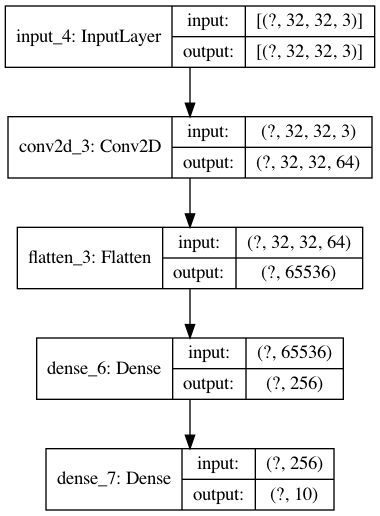

In [14]:
keras.utils.plot_model(fn_model, show_shapes=True)

## 레이어를 합치는 함수
- concatenate(list, axis=-1)
    - 레이어들을 합친다
    - list: 합칠 레이어들을 리스트에 묶어 전달
    - axis: 합칠 기준축. (기본값: -1 : 마지막 축기준)
- add(list), substract(list), multiply(list)
    - 같은 index의 값들을 계산해서(더하기, 빼기, 곱하기) 하나의 레이어로 만든다.
    - list: 합칠 레이어들을 리스트에 묶어 전달

In [18]:
# Residual Block
input_tensor = layers.Input((32, 32, 3))
x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(input_tensor)
x1 = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
b1 = layers.BatchNormalization()(x1)
add1 = layers.add([x, b1])
r = layers.ReLU()(add1)

r_block_model = models.Model(input_tensor, r)

In [19]:
r_block_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 64)   1792        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 32, 64)   36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 32, 32, 64)   256         conv2d_11[0][0]                  
____________________________________________________________________________________________

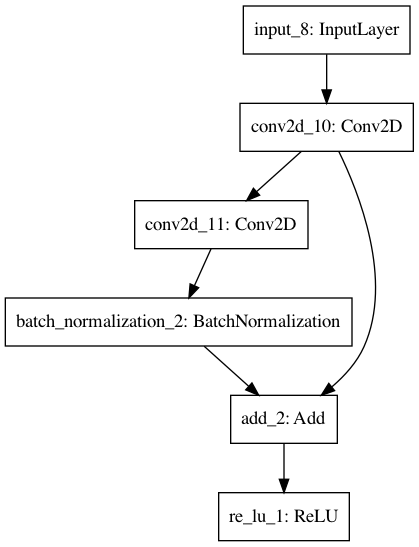

In [20]:
keras.utils.plot_model(r_block_model)

In [4]:
!pip show scikit-learn

Name: scikit-learn
Version: 0.23.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: sklearn


### 다중 출력 모델
- 가정
    - iris 데이터셋에서 꽃받침의 너비와 높이로 꽃잎의 너비, 높이, 꽃 종류를 예측하는 모델
    - 출력결과가 3개가 나와야 한다.
- X: 꽃받침 너비, 높이
- y: 꽃잎 너비, 높이, 꽃 종류

In [5]:
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris['data'], iris['target']
X.shape, y.shape

((150, 4), (150,))

In [6]:
X[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [7]:
y1 = X[:, 2]  # 꽃잎의 너비
y2 = X[:, 3]  # 꽃잎의 높이
y3 = y  # 품종(3종)

X = X[:, [0,1]]

In [8]:
X.shape, y1.shape, y2.shape, y3.shape

((150, 2), (150,), (150,), (150,))

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [10]:
input_tensor = layers.Input((2, ))
x = layers.Dense(units=16, activation='relu')(input_tensor)
x = layers.Dense(units=8, activation='relu')(x)
output1 = layers.Dense(units=1, name='petal_width_output')(x)  # 꽃잎의 너비를 예측(Regression: units=1, activation=X)
output2 = layers.Dense(units=1, name='petal_length_output')(x)  # 꽃잎의 높이를 예측(Regression: units=1, activation=X)
output3 = layers.Dense(units=3, activation='softmax', name='species_output')(x)  # 품종 예측(다중분류: units=class개수(3), activation=softmax)

model = models.Model(input_tensor, [output1, output2, output3])  # Model(input, output), input이나 output이 여러개인 경우에는 리스트로 묶어서 사용

In [11]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 16)           48          input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 8)            136         dense_4[0][0]                    
__________________________________________________________________________________________________
petal_width_output (Dense)      (None, 1)            9           dense_5[0][0]                    
____________________________________________________________________________________________

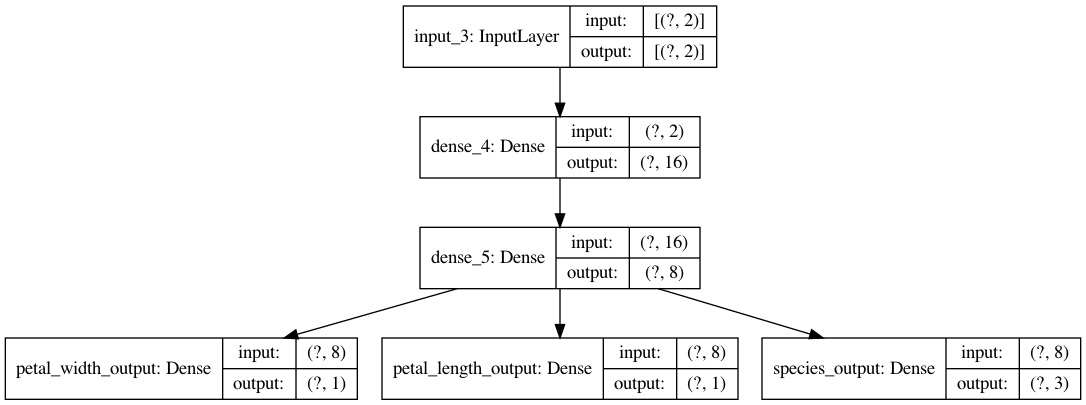

In [12]:
keras.utils.plot_model(model, show_shapes=True)

In [13]:
# compile
model.compile(optimizer='adam',
              loss=['mse', 'mse', 'sparse_categorical_crossentropy'],  # 출력이 3개 - 각각의 loss를 쌓은 순서대로 리스트로 묶어서 제공
             )
# 역전파를 통해 weight를 업데이트할 때는 위 3개의 loss를 더한 총 loss로 역전파한다.

In [14]:
history = model.fit(X,
                    [y1, y2, y3],  # 출력과 순서를 맞춰줘야 한다.
                    epochs=100,
                    validation_split=0.1                    
                   )

Train on 135 samples, validate on 15 samples
Epoch 1/100
135/135 [==============================] - 1s 7ms/sample - loss: 10.5254 - petal_width_output_loss: 7.4677 - petal_length_output_loss: 1.2070 - species_output_loss: 1.6468 - val_loss: 17.5101 - val_petal_width_output_loss: 13.5840 - val_petal_length_output_loss: 3.3252 - val_species_output_loss: 0.6009
Epoch 2/100
135/135 [==============================] - 0s 119us/sample - loss: 9.5757 - petal_width_output_loss: 6.3691 - petal_length_output_loss: 1.0252 - species_output_loss: 1.8854 - val_loss: 15.5963 - val_petal_width_output_loss: 11.9116 - val_petal_length_output_loss: 3.0709 - val_species_output_loss: 0.6137
Epoch 3/100
135/135 [==============================] - 0s 109us/sample - loss: 8.7738 - petal_width_output_loss: 5.4696 - petal_length_output_loss: 0.9140 - species_output_loss: 1.8504 - val_loss: 13.8243 - val_petal_width_output_loss: 10.3867 - val_petal_length_output_loss: 2.8116 - val_species_output_loss: 0.6260
Epoch

Epoch 27/100
135/135 [==============================] - 0s 107us/sample - loss: 3.8386 - petal_width_output_loss: 2.0383 - petal_length_output_loss: 0.2608 - species_output_loss: 1.5242 - val_loss: 3.7704 - val_petal_width_output_loss: 2.2338 - val_petal_length_output_loss: 0.7635 - val_species_output_loss: 0.7731
Epoch 28/100
135/135 [==============================] - 0s 110us/sample - loss: 3.7689 - petal_width_output_loss: 2.0358 - petal_length_output_loss: 0.2538 - species_output_loss: 1.4634 - val_loss: 3.7860 - val_petal_width_output_loss: 2.2372 - val_petal_length_output_loss: 0.7683 - val_species_output_loss: 0.7805
Epoch 29/100
135/135 [==============================] - 0s 135us/sample - loss: 3.7040 - petal_width_output_loss: 1.9427 - petal_length_output_loss: 0.2627 - species_output_loss: 1.4297 - val_loss: 3.7873 - val_petal_width_output_loss: 2.2284 - val_petal_length_output_loss: 0.7720 - val_species_output_loss: 0.7868
Epoch 30/100
135/135 [==============================

Epoch 53/100
135/135 [==============================] - 0s 115us/sample - loss: 2.4384 - petal_width_output_loss: 1.1297 - petal_length_output_loss: 0.1856 - species_output_loss: 1.0593 - val_loss: 3.0797 - val_petal_width_output_loss: 1.4847 - val_petal_length_output_loss: 0.6099 - val_species_output_loss: 0.9852
Epoch 54/100
135/135 [==============================] - 0s 139us/sample - loss: 2.4008 - petal_width_output_loss: 1.1205 - petal_length_output_loss: 0.1714 - species_output_loss: 1.0583 - val_loss: 3.0139 - val_petal_width_output_loss: 1.4292 - val_petal_length_output_loss: 0.5895 - val_species_output_loss: 0.9952
Epoch 55/100
135/135 [==============================] - 0s 121us/sample - loss: 2.3603 - petal_width_output_loss: 1.0961 - petal_length_output_loss: 0.1682 - species_output_loss: 1.0615 - val_loss: 2.9255 - val_petal_width_output_loss: 1.3446 - val_petal_length_output_loss: 0.5742 - val_species_output_loss: 1.0068
Epoch 56/100
135/135 [==============================

Epoch 79/100
135/135 [==============================] - 0s 116us/sample - loss: 1.4647 - petal_width_output_loss: 0.4617 - petal_length_output_loss: 0.1526 - species_output_loss: 0.8650 - val_loss: 2.5170 - val_petal_width_output_loss: 0.9558 - val_petal_length_output_loss: 0.5430 - val_species_output_loss: 1.0182
Epoch 80/100
135/135 [==============================] - 0s 99us/sample - loss: 1.4519 - petal_width_output_loss: 0.4038 - petal_length_output_loss: 0.1423 - species_output_loss: 0.8529 - val_loss: 2.4560 - val_petal_width_output_loss: 0.9185 - val_petal_length_output_loss: 0.5254 - val_species_output_loss: 1.0120
Epoch 81/100
135/135 [==============================] - 0s 95us/sample - loss: 1.4406 - petal_width_output_loss: 0.3938 - petal_length_output_loss: 0.1363 - species_output_loss: 0.8536 - val_loss: 2.4534 - val_petal_width_output_loss: 0.9261 - val_petal_length_output_loss: 0.5196 - val_species_output_loss: 1.0077
Epoch 82/100
135/135 [==============================] 

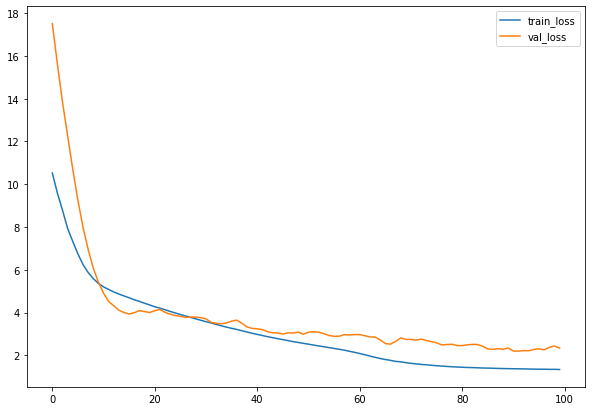

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

In [16]:
model.evaluate(X, [y1, y2, y3])
# [총 loss, output1 loss, output2 loss, output3 loss]

150/150 [==============================] - 0s 79us/sample - loss: 1.4338 - petal_width_output_loss: 0.4768 - petal_length_output_loss: 0.1868 - species_output_loss: 0.8067


[1.4337866338094076, 0.47683287, 0.18683133, 0.80671155]

In [18]:
# 추론
model.predict(X[:2])

[array([[1.7147067],
        [2.2769563]], dtype=float32),
 array([[0.42830962],
        [0.6442192 ]], dtype=float32),
 array([[0.51050407, 0.25634414, 0.23315172],
        [0.37664172, 0.3324472 , 0.29091108]], dtype=float32)]

## 다중 입력 모델
- 가정 
    - IRIS 꽃 데이터 + 꽃의 사진을 입력해서 꽃의 종류를 예측한다.
- X: 꽃 데이터, 꽃 사진
- y: 꽃 종류

In [19]:
iris_info_tensor = layers.Input((4, ))
x1 = layers.Dense(32, activation='relu')(iris_info_tensor)
x1 = layers.Dense(16, activation='relu')(x1)

iris_image_tensor = layers.Input((16, 16, 1))
x2 = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(iris_image_tensor)
x2 = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x2)
x2 = layers.MaxPool2D(padding='same')(x2)

x3 = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x2)
x3 = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x3)
x3 = layers.MaxPool2D(padding='same')(x3)
x3 = layers.GlobalAveragePooling2D()(x3)

# 합치기
x4 = layers.concatenate([x1, x3])
x5 = layers.Dropout(0.2)(x4)
output_tensor = layers.Dense(3, activation='softmax')(x5)

model = models.Model([iris_info_tensor, iris_image_tensor], output_tensor)

In [20]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 16, 16, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 32)   9248        conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 32)     0           conv2d_3[0][0]                   
____________________________________________________________________________________________

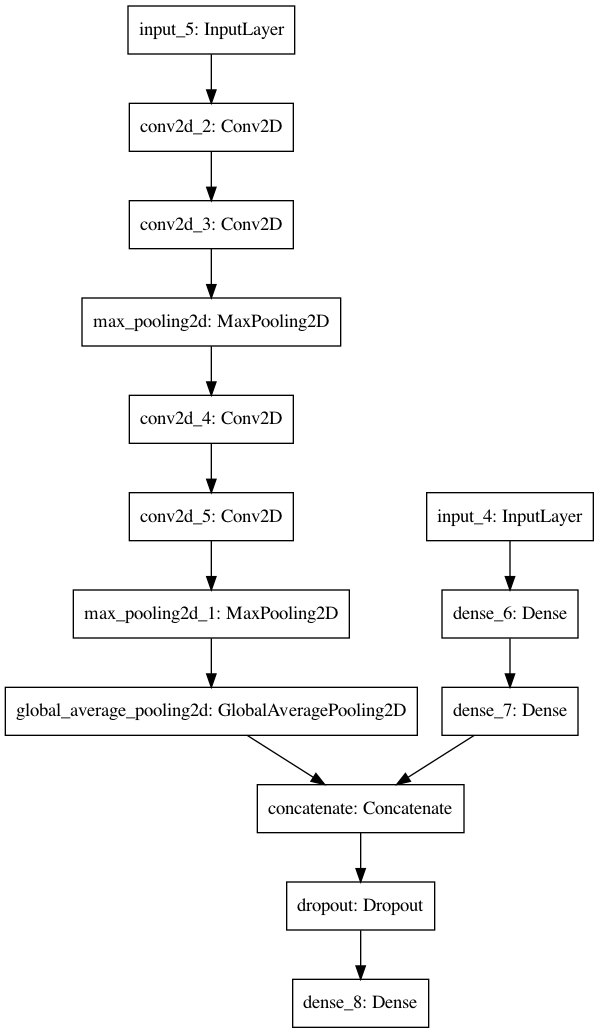

In [21]:
keras.utils.plot_model(model)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )